In [10]:
from scipy.signal import stft
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from collections import Counter
from IPython.display import display, Markdown
from IPython.display import display, Markdown
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 0) Load real birdsong from a .flac file

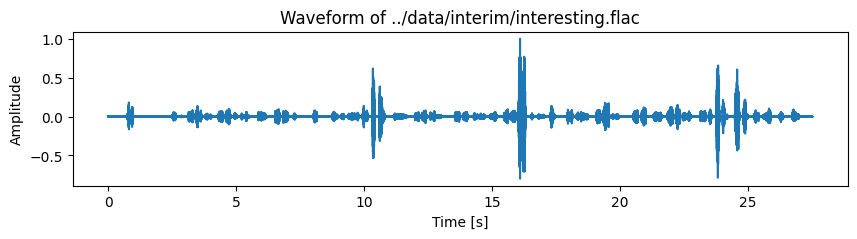

In [11]:
filename = "../data/interim/interesting.flac"

# Load
y, sr = sf.read(filename)
if y.ndim > 1:
    y = np.mean(y, axis=1)  # convert stereo to mono

# normalize
y = y / np.max(np.abs(y))

duration = len(y) / sr
t = np.linspace(0, duration, len(y), endpoint=False)

plt.figure(figsize=(10, 2))
plt.plot(t, y)
plt.title(f"Waveform of {filename}")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


# 1) Generate a synthetic birdsong
Create a simple test signal made of repeated chirp-like syllables with noise.

In [12]:
# sr = 8000; duration = 8.0
# t = np.linspace(0, duration, int(sr*duration), endpoint=False)
# rng = np.random.default_rng(42)

# def syllable_a(tt): 
#     f0,f1=800,1800
#     phase=2*np.pi*(f0*tt+0.5*(f1-f0)*tt**2/tt[-1])
#     env=np.exp(-((tt-tt[-1]/2)**2)/(2*(tt[-1]/6)**2))
#     return 0.7*env*np.sin(phase)
# def syllable_b(tt): 
#     f0,f1=1800,600
#     phase=2*np.pi*(f0*tt+0.5*(f1-f0)*tt**2/tt[-1])
#     env=np.exp(-((tt-tt[-1]/2)**2)/(2*(tt[-1]/7)**2))
#     return 0.7*env*np.sin(phase)
# def syllable_c(tt): 
#     f=1200
#     env=(np.sin(2*np.pi*20*tt)>0).astype(float)
#     window=np.hanning(len(tt))
#     return 0.5*window*env*np.sin(2*np.pi*f*tt)

# syllables=[syllable_a,syllable_b,syllable_c]
# syll_dur=0.15
# tt=np.linspace(0,syll_dur,int(sr*syll_dur),endpoint=False)
# y=np.zeros_like(t)
# events=[]
# cursor=0.3
# while cursor<duration-0.3:
#     gap=rng.uniform(0.1,0.35)
#     cursor+=gap
#     if cursor+syll_dur>duration-0.05: break
#     k=rng.integers(0,len(syllables))
#     start_idx=int(cursor*sr)
#     y[start_idx:start_idx+len(tt)]+=syllables[k](tt)
#     events.append((cursor,cursor+syll_dur,int(k)))
#     cursor+=syll_dur
# y+=rng.normal(scale=0.03,size=len(y))
# plt.figure(figsize=(10,2))
# plt.plot(t,y)
# for (s,e,k) in events: plt.axvspan(s,e,alpha=0.2)
# plt.title('Synthetic birdsong waveform')
# plt.xlabel('Time [s]')
# plt.show()

# 2) Spectrogram preprocessing

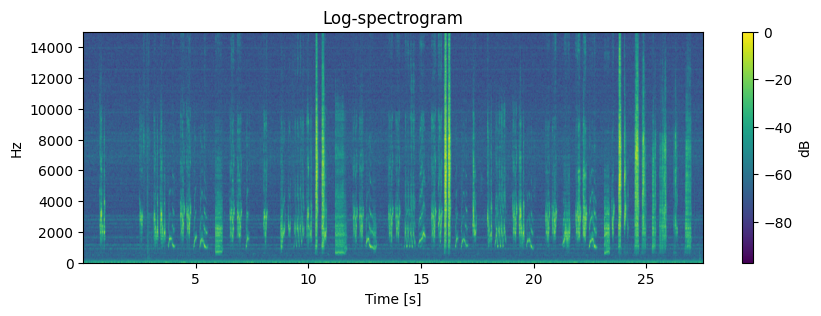

In [13]:
n_fft=512; hop=128
f, tt_spec, Z = stft(y, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, boundary=None)
S = np.abs(Z)+1e-6
S_log = 20*np.log10(S/S.max())

plt.figure(figsize=(10,3))
plt.imshow(S_log, aspect='auto', origin='lower', extent=[tt_spec[0], tt_spec[-1], f[0], f[-1]])
plt.title("Log-spectrogram"); plt.xlabel("Time [s]"); plt.ylabel("Hz"); plt.colorbar(label="dB"); plt.show()


# 3) Event detection

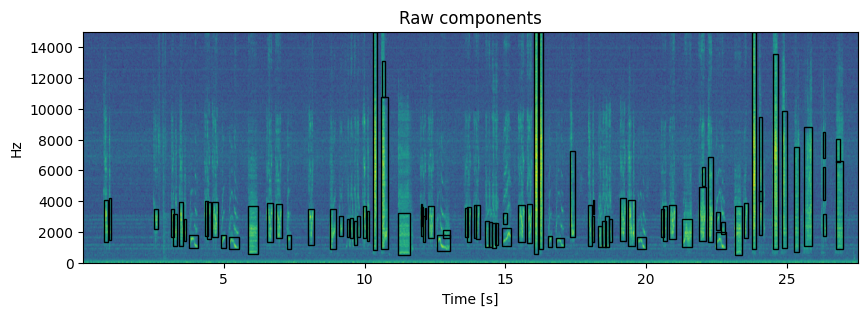

Raw components: 88


In [14]:
eta_db=-40.0
mask = (S_log > eta_db).astype(np.uint8)
labeled = label(mask, connectivity=2)
raw_regions = [r for r in regionprops(labeled) if 100 <= r.area <= 25000]

plt.figure(figsize=(10,3))
plt.imshow(S_log, aspect='auto', origin='lower', extent=[tt_spec[0], tt_spec[-1], f[0], f[-1]])
for r in raw_regions:
    minr, minc, maxr, maxc = r.bbox
    t0,t1 = tt_spec[minc], tt_spec[maxc-1]; f0,f1=f[minr],f[maxr-1]
    plt.gca().add_patch(plt.Rectangle((t0,f0), t1-t0, f1-f0, fill=False, linewidth=1))
plt.title("Raw components"); plt.xlabel("Time [s]"); plt.ylabel("Hz"); plt.show()

print(f"Raw components: {len(raw_regions)}")


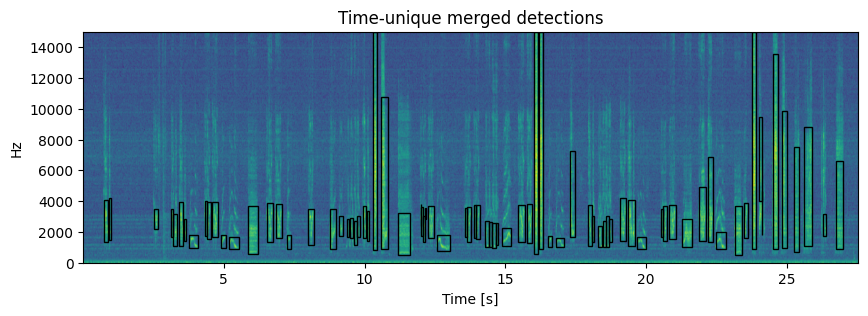

Merged detections (max one per time frame): 78


In [15]:
# 3b) Enforce one detection per time frame by merging
def region_energy(r):
    minr, minc, maxr, maxc = r.bbox
    return S[minr:maxr, minc:maxc].sum()

scores = np.array([region_energy(r) for r in raw_regions])
T_frames = S.shape[1]
best_region_at_frame = -np.ones(T_frames, dtype=int)
best_score_at_frame = np.full(T_frames, -np.inf)
for ridx,r in enumerate(raw_regions):
    minr, minc, maxr, maxc = r.bbox
    for c in range(minc, maxc):
        if scores[ridx] > best_score_at_frame[c]:
            best_score_at_frame[c]=scores[ridx]; best_region_at_frame[c]=ridx

# Collapse contiguous frame runs to segments
segments = []
start=None; prev=-2
for c in range(T_frames):
    cur = best_region_at_frame[c]
    if cur!=prev:
        if start is not None: segments.append((start,c,prev))
        start=c; prev=cur
if start is not None: segments.append((start,T_frames,prev))

# Build merged regions as bboxes that respect segment time and union frequency of the winning region
merged_regions = []
for (c0,c1,ridx) in segments:
    if ridx<0: continue
    r = raw_regions[ridx]
    rminr, rminc, rmaxr, rmaxc = r.bbox
    merged_regions.append( (int(min(rminr,rminr)), int(c0), int(max(rmaxr,rmaxr)), int(c1)) )

plt.figure(figsize=(10,3))
plt.imshow(S_log, aspect='auto', origin='lower', extent=[tt_spec[0], tt_spec[-1], f[0], f[-1]])
for (minr, minc, maxr, maxc) in merged_regions:
    t0,t1 = tt_spec[minc], tt_spec[maxc-1]; f0,f1=f[minr],f[maxr-1]
    plt.gca().add_patch(plt.Rectangle((t0,f0), t1-t0, f1-f0, fill=False, linewidth=1))
plt.title("Time-unique merged detections"); plt.xlabel("Time [s]"); plt.ylabel("Hz"); plt.show()

print(f"Merged detections (max one per time frame): {len(merged_regions)}")


# 4) Dimensionality reduction and clustering

Built 78 variable-length sequences. Example shapes: (37, 8) …
DTW distance matrix computed.
HDBSCAN clusters: 2  (label -1 are outliers)
Cluster sizes: {np.int64(0): 56, np.int64(1): 14}
Noise fraction: 10.26%


/home/jaeho/NYU/budgie/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/jaeho/NYU/budgie/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


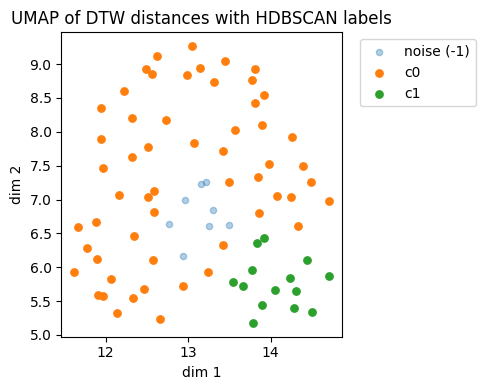

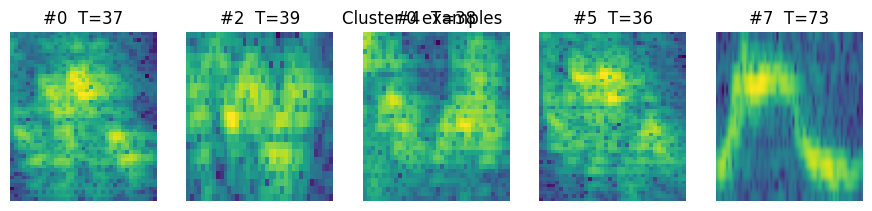

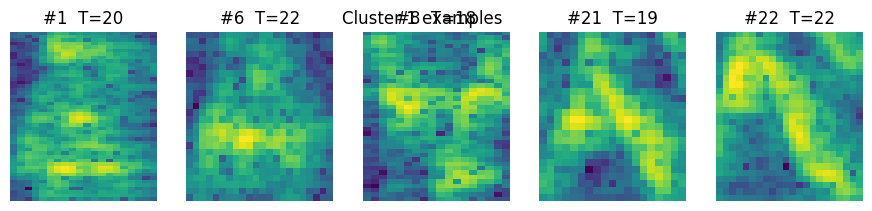

In [ ]:
# %% [markdown]
# # 4) Variable-length clustering with DTW distances (no fixed box)
# Build a per-detection feature sequence, compute a DTW distance matrix with a Sakoe–Chiba band,
# then cluster with HDBSCAN on the precomputed distances. Optionally embed with UMAP (precomputed).

# %%
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap

# ----------------------- 1) Per-detection feature sequences -----------------------
# For each merged region bbox, take the log-spectrogram slice [minr:maxr, minc:maxc].
# Split its frequency rows into B bands and use band-mean energies per time frame as features.
BANDS = 8          # number of frequency bands per detection
DOWNSAMPLE = 1     # temporal downsample factor (>=1). Use 2 or 3 for speed on long syllables.
Z_NORM = True      # z-score each sequence bandwise for invariance

def slice_to_sequence(Slog, bbox, n_bands=BANDS, ds=DOWNSAMPLE, z_norm=Z_NORM):
    minr, minc, maxr, maxc = bbox
    patch = Slog[minr:maxr, minc:maxc]          # [Fr, Tc]
    # split frequency into n_bands bins
    rows = np.array_split(np.arange(patch.shape[0]), n_bands)
    # per-time band means -> [Tc, n_bands]
    feat = np.stack([patch[r,:].mean(axis=0) for r in rows], axis=1)
    if ds > 1:
        feat = feat[::ds, :]
    if z_norm:
        mu = feat.mean(axis=0, keepdims=True)
        sd = feat.std(axis=0, keepdims=True) + 1e-8
        feat = (feat - mu) / sd
    return feat.astype(np.float32)  # shape [Ti, n_bands]

X_list = [slice_to_sequence(S_log, bbox) for bbox in merged_regions]
N = len(X_list)
print(f"Built {N} variable-length sequences. Example shapes:", X_list[0].shape, "…")

# ----------------------- 2) Banded DTW distance (multivariate) -----------------------
# Multivariate DTW using Euclidean frame cost, Sakoe–Chiba band width as fraction of max length.
def dtw_distance(a, b, band_frac=0.1):
    # a: [Ta, D], b: [Tb, D]
    Ta, Tb = len(a), len(b)
    if Ta == 0 or Tb == 0:
        return np.inf
    W = int(band_frac * max(Ta, Tb))
    INF = 1e20
    # DP grid with padding
    DP = np.full((Ta+1, Tb+1), INF, dtype=np.float64)
    DP[0,0] = 0.0
    for i in range(1, Ta+1):
        j_start = max(1, i - W)
        j_end   = min(Tb, i + W)
        ai = a[i-1]
        for j in range(j_start, j_end+1):
            cost = np.linalg.norm(ai - b[j-1])
            DP[i,j] = cost + min(DP[i-1,j], DP[i,j-1], DP[i-1,j-1])
    return float(DP[Ta, Tb])

# Optionally speed up by computing on a subset or with caching. Here we compute full N×N.
band_frac = 0.10  # 10% warping window
Dmat = np.zeros((N, N), dtype=np.float64)
for i in range(N):
    for j in range(i+1, N):
        d = dtw_distance(X_list[i], X_list[j], band_frac=band_frac)
        Dmat[i, j] = Dmat[j, i] = d
np.fill_diagonal(Dmat, 0.0)
print("DTW distance matrix computed.")

# ----------------------- 3) HDBSCAN on precomputed distances -----------------------
clusterer = hdbscan.HDBSCAN(metric="precomputed", min_cluster_size=5, min_samples=2)
labels = clusterer.fit_predict(Dmat)
n_clusters = len(set(labels) - {-1})
print(f"HDBSCAN clusters: {n_clusters}  (label -1 are outliers)")

# cluster sizes and noise rate
from collections import Counter
counts = Counter(labels[labels!=-1])
noise_frac = np.mean(labels==-1)
print("Cluster sizes:", dict(counts))
print(f"Noise fraction: {noise_frac:.2%}")

# ----------------------- 4) Optional UMAP visualization (precomputed) -----------------------
if HAVE_UMAP:
    reducer = umap.UMAP(metric="precomputed", random_state=0)
    Z2 = reducer.fit_transform(Dmat)
    plt.figure(figsize=(5,4))
    m = labels==-1
    plt.scatter(Z2[m,0], Z2[m,1], s=20, alpha=0.35, label="noise (-1)")
    for c in sorted(set(labels) - {-1}):
        plt.scatter(Z2[labels==c,0], Z2[labels==c,1], s=28, label=f"c{c}")
    plt.title("UMAP of DTW distances with HDBSCAN labels")
    plt.xlabel("dim 1"); plt.ylabel("dim 2")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout(); plt.show()

# ----------------------- 5) Quick visual audit: show a few spectrogram slices per cluster -----------------------
def show_examples_varlen(label_id, max_examples=6):
    idx = np.where(labels == label_id)[0]
    n = min(max_examples, len(idx))
    if n == 0:
        return
    fig, axs = plt.subplots(1, n, figsize=(2.2*n, 2.2))
    if n == 1:
        axs = [axs]
    for j in range(n):
        minr, minc, maxr, maxc = merged_regions[idx[j]]
        patch = S_log[minr:maxr, minc:maxc]
        axs[j].imshow(patch, aspect='auto', origin='lower')
        axs[j].set_title(f"#{idx[j]}  T={patch.shape[1]}")
        axs[j].axis('off')
    fig.suptitle(f"Cluster {label_id} examples")
    plt.show()

for c in sorted(set(labels) - {-1}):
    show_examples_varlen(c, max_examples=5)


In [17]:
# box_t,box_f=18,40
# def extract_patch(S,r):
#     minr,minc,maxr,maxc=r.bbox
#     patch=S[minr:maxr,minc:maxc]
#     pad_r=max(0,box_f-patch.shape[0]); pad_c=max(0,box_t-patch.shape[1])
#     patch=np.pad(patch,((pad_r//2,pad_r-pad_r//2),(pad_c//2,pad_c-pad_c//2)),mode='constant',constant_values=S.min())
#     return patch[:box_f,:box_t]
# patches=np.stack([extract_patch(S_log,r) for r in regions]); X=patches.reshape(len(patches),-1)
# pca=PCA(n_components=3).fit(X); Z3=pca.transform(X)
# try:
#     db=DBSCAN(eps=1.2,min_samples=3).fit(Z3); labels=db.labels_
#     if len(set(labels)-{-1})==0: raise ValueError
# except: labels=KMeans(n_clusters=3,n_init=10).fit(Z3).labels_
# n_clusters=len(set(labels))
# from mpl_toolkits.mplot3d import Axes3D
# fig=plt.figure(figsize=(5,4)); ax=fig.add_subplot(111,projection='3d')
# ax.scatter(Z3[:,0],Z3[:,1],Z3[:,2],c=labels); ax.set_title('PCA clustering'); plt.show()

# 5) Template construction

In [18]:
from collections import Counter

# Remap labels to {0..C-1}, drop -1 (noise)
uniq = sorted([l for l in set(labels) if l != -1])
label_map = {l:i for i,l in enumerate(uniq)}
labels_remap = np.array([label_map.get(l, -1) for l in labels])

# Report member counts per original and remapped labels
print("Cluster counts (raw):", Counter(labels))
print("Cluster counts (remapped, -1 removed):", Counter(labels_remap[labels_remap!=-1]))

# Build median templates per cluster, skipping tiny clusters
min_members = 2  # set to 1 if you want to keep singletons
templates = []
kept_label_ids = []

for c in range(len(uniq)):
    idx = np.where(labels_remap == c)[0]
    if len(idx) < min_members:
        continue
    T = np.median(patches[idx], axis=0)
    templates.append(T)
    kept_label_ids.append(c)

n_templates = len(templates)
print(f"Templates kept: {n_templates} (min_members={min_members})")

# Visualize
if n_templates > 0:
    fig, axs = plt.subplots(1, n_templates, figsize=(3*n_templates, 3))
    axs = np.atleast_1d(axs)
    for j, T in enumerate(templates):
        axs[j].imshow(T, aspect='auto', origin='lower')
        axs[j].set_title(f"Template {j}")
        axs[j].axis('off')
    plt.show()
else:
    print("No templates to show; relax thresholds or min_members.")


Cluster counts (raw): Counter({np.int64(0): 56, np.int64(1): 14, np.int64(-1): 8})
Cluster counts (remapped, -1 removed): Counter({np.int64(0): 56, np.int64(1): 14})


NameError: name 'patches' is not defined

# 6) Template merging

In [ ]:
Tmat=np.stack(templates).reshape(n_clusters,-1)
def norm_dist_matrix(M):
    n=len(M); D=np.zeros((n,n)); norms=np.linalg.norm(M,axis=1)
    for i in range(n):
        for j in range(i+1,n):
            d=np.linalg.norm(M[i]-M[j])/max(norms[i],norms[j])
            D[i,j]=D[j,i]=d
    return D
D=norm_dist_matrix(Tmat); Zlink=linkage(squareform(D),method='complete')
groups=fcluster(Zlink,t=0.2,criterion='distance')
merged_templates=[np.median(np.stack([templates[i] for i in np.where(groups==g)[0]]),axis=0) for g in np.unique(groups)]
fig,axs=plt.subplots(1,len(merged_templates),figsize=(3*len(merged_templates),3))
for j,T in enumerate(merged_templates): axs[j].imshow(T,aspect='auto',origin='lower'); axs[j].set_title(f'Merged {j}')
plt.show()

# 7) Matching pursuit inference

In [ ]:
temp_time=[(T.sum(axis=0)-np.mean(T.sum(axis=0)))/(np.std(T.sum(axis=0))+1e-8) for T in merged_templates]
band=(f>700)&(f<1900); S_band=(S_log[band].mean(axis=0)-S_log[band].mean())/S_log[band].std()
def correlate_template(x,w): return np.correlate(x,w,mode='same')
scores=np.stack([correlate_template(S_band,t) for t in temp_time])
collar=int(0.10*sr/hop)
thresh=np.percentile(scores,90.5); cand=np.argwhere(scores>=thresh)
cand=sorted([(int(ti),int(ki),float(scores[ki,ti])) for (ki,ti) in cand],key=lambda z:-z[2])
used=np.zeros(scores.shape[1],bool); assign=[]
for t_idx,k,sc in cand:
    if used[t_idx]: continue
    assign.append((t_idx,k,sc))
    left=max(0,t_idx-collar); right=min(scores.shape[1],t_idx+collar+1); used[left:right]=True
plt.figure(figsize=(10,3)); plt.imshow(S_log,aspect='auto',origin='lower',extent=[tt_spec[0],tt_spec[-1],f[0],f[-1]])
for t_idx,k,sc in assign:
    t0=tt_spec[max(0,t_idx-box_t//2)]; t1=tt_spec[min(len(tt_spec)-1,t_idx+box_t//2)]
    plt.axvspan(t0,t1,alpha=0.35)
plt.title('Placements after thresholding'); plt.show()

# 8) Evaluation

In [ ]:
det_times=[((tt_spec[r.bbox[1]]+tt_spec[r.bbox[3]-1])/2.0,r) for r in regions]
gt_times=[((s+e)/2.0,k) for (s,e,k) in events]; tol=0.12
used_gt=np.zeros(len(gt_times),bool); matches=[]
for tcenter,r in det_times:
    diffs=[abs(tcenter-g[0]) if not used_gt[i] else np.inf for i,g in enumerate(gt_times)]
    j=int(np.argmin(diffs))
    if diffs[j]<=tol: used_gt[j]=True; matches.append((tcenter,j,r))
tp=len(matches); fp=len(det_times)-tp; fn=np.sum(~used_gt)
print('Detection precision',tp/(tp+fp+1e-9),'recall',tp/(tp+fn+1e-9))